# Edge Coupler

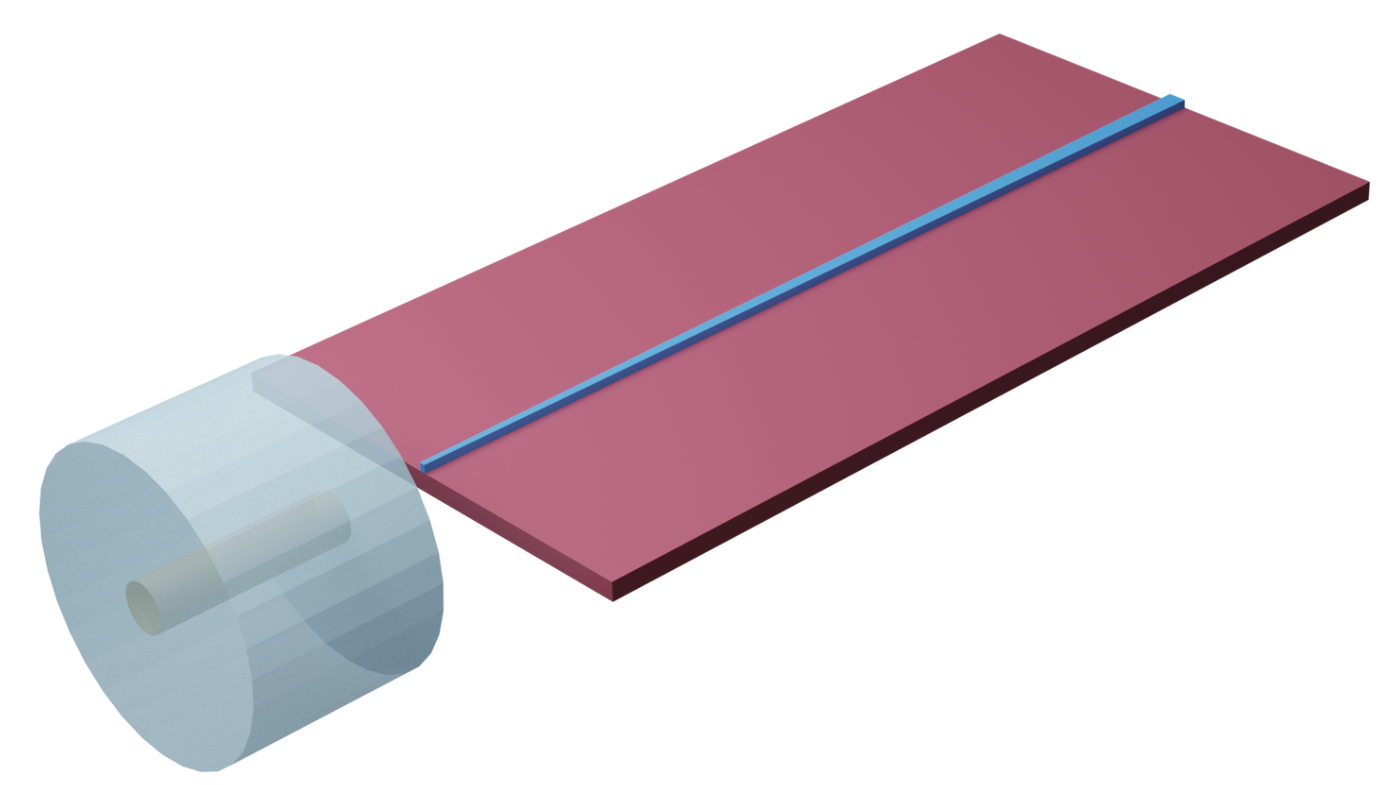

In this example, we'll explore the simulation of edge couplers using PhotonForge.
Edge couplers are essential components for efficiently coupling light into and out of photonic chips.
Typically, optimized edge coupler designs minimize both the insertion loss and the return loss.
The geometry of the edge coupler and the medium between the fiber and chip facet significantly impact these performance metrics.

This notebook demonstrates how to use [3D Gaussian Ports](../_autosummary/photonforge.GaussianPort.rst) in to simulate light emission from a fiber, providing an intuitive approach to simulating scattering matrices for edge couplers.
To see how they can also be used with vertical coupling, please refer to the [grating coupler example](Grating_Coupler.ipynb).

We first begin by showing how to set up a Gaussian port to compute the scattering matrix for a simple inverse taper edge coupler.
After that, we also look at designing an improved version with an angled edge coupler.

In [1]:
import photonforge as pf
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt
import tidy3d.web as web

We will use the [basic technology](../_autosummary/photonforge.basic_technology.rst) for Silicon photonics that comes with PhotonForge.
One parameter that we will require for positioning our Gaussian port is the thickness of the core layer of our device, so we set it here as well.

In [2]:
core_thickness = 0.22

tech = pf.basic_technology(core_thickness=0.22)
pf.config.default_technology = tech

## Simple Inverse Taper

Let's build a [parametric component](../guides/Custom_Parametric_Components.ipynb) to specify our edge coupler, including its ports and model.

We will use the default strip waveguide as base for the inverse taper, so we get a few dimensions from it, knowing that in the basic technology, waveguides are always surrounded by a cladding region.

In [3]:
port_spec = tech.ports["Strip"]
core_width, _ = port_spec.path_profile_for("WG_CORE")
clad_width, _ = port_spec.path_profile_for("WG_CLAD")

In [4]:
@pf.parametric_component
def create_edge_coupler(*, width_tip=0.1, length_taper=10, waist_radius=2.0):
    component = pf.Component()
    component.add(
        "WG_CORE",
        pf.stencil.linear_taper(length_taper, (width_tip, core_width)),
        "WG_CLAD",
        pf.stencil.linear_taper(length_taper, (4 * waist_radius, clad_width)),
    )

    # The Gaussian port must be placed over homogeneous medium, so we add a tiny gap from the taper tip
    port_fiber = pf.GaussianPort(
        center=(-width_tip / 2, 0, core_thickness / 2),
        input_vector=(1, 0, 0),
        waist_radius=waist_radius,
        polarization_angle=0,  # for TE mode, in this case
    )
    port_waveguide = pf.Port((length_taper, 0), 180, port_spec)

    component.add_port([port_fiber, port_waveguide])

    model = pf.Tidy3DModel(
        port_symmetries=[("P0", "P1", {"P1": "P0"})],
        symmetry=(0, -1, 0),
    )
    component.add_model(model, "Tidy3D")
    return component


create_edge_coupler()

Note that we have defined Gaussian port as a source to inject light directly into the waveguide, which is not realistic.
We will improve on that later.

For now, let's create an inverse taper edge coupler with a 150 nm tip and a taper length of 25 μm.
We will assume that we are using a lensed fiber of 2.5 μm spot size to couple light into the chip.

In [5]:
edge_coupler = create_edge_coupler(
    width_tip=0.15,
    length_taper=25,
    waist_radius=2.5 / 2,
)
edge_coupler

Let's plot the simulation domain to make sure the Gaussian port is setup properly.

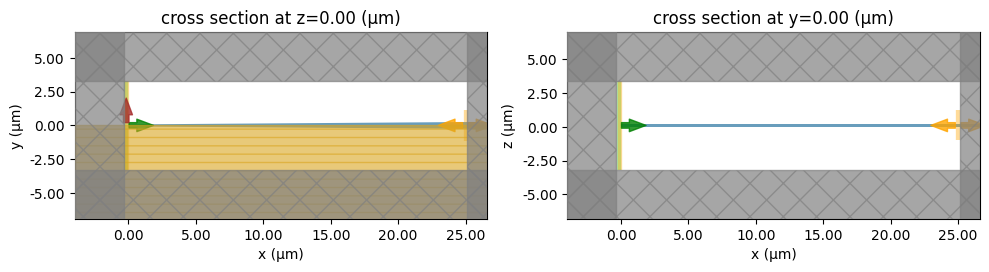

In [6]:
wavelengths = np.linspace(1.5, 1.6, 21)

_, ax = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)

sims = edge_coupler.models["Tidy3D"].get_simulations(edge_coupler, pf.C_0 / wavelengths)
_ = sims["P0@0"].plot(z=0, ax=ax[0])
_ = sims["P0@0"].plot(y=0, ax=ax[1])

Next, we compute and plot the [S matrix](../guides/S_Parameters.ipynb):

Loading cached simulation from .tidy3d/pf_cache/7DG/fdtd_info-CX2TXWREDWFHW6OB6HOWEXDU2A7GTMWQGZQK4AE7QW3A4CAO4B7Q.json.
Loading cached simulation from .tidy3d/pf_cache/7DG/ms_info-6SWJGEYXS7JYHIJCSHSVVT4IP23VNONGPJPSUGEIGWSSIDVWGAWQ.json.
Progress: 100% 


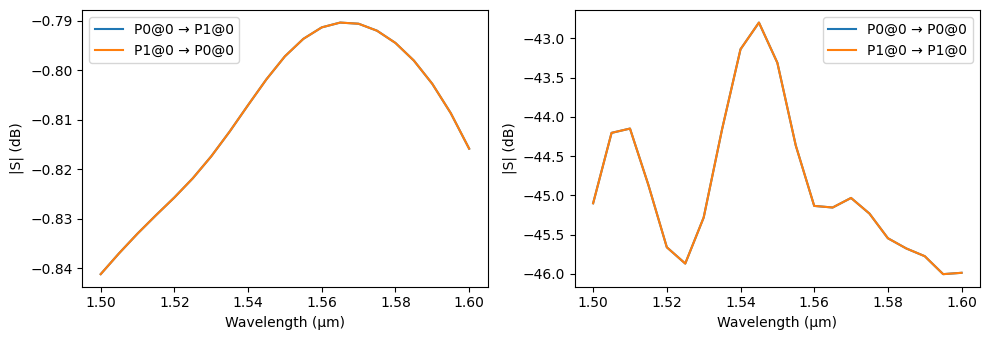

In [7]:
_ = pf.plot_s_matrix(edge_coupler.s_matrix(pf.C_0 / wavelengths), y="dB", threshold=0.2)

We see an insertion loss below 0.9 dB in the whole wavelength range when the Gaussian mode is launched right at the tip of the edge coupler.
The return loss is quite low overall, well below -40 dB.

However, in real devices, the Gaussian mode is launched through a lensed or cleaved single mode fiber at some distance away from the chip.
More importantly, the gap between the fiber and the chip might have an index matching fluid with index of refraction that tries to match the waveguide cladding.

Next, we will simulate two different cases with the fiber positioned at a fixed distance from the chip: with and without the index matching fluid.

### Air Gap

Since our current technology specifies SiO₂ as the background medium we need to define the region with air beyond the chip facet.
In the basic technology we can use the "TRENCH" layer to open an air gap anywhere in the component.

In [8]:
tech.layers

Name   Layer             Description               Color    Pattern
---------------------------------------------------------------------
WG_CLAD  (1, 0)  Waveguide clad                    #9da6a218     .   
WG_CORE  (2, 0)  Waveguide core                    #6db5dd18     /   
SLAB     (3, 0)  Slab region                       #8851ad18     :   
TRENCH   (4, 0)  Deep-etched trench for chip fac…  #535e5918     +   
METAL    (5, 0)  Metal layer                       #b8a18b18     \

When we create the model, we want the trench to extend over the absorbing boundaries, but, by default, the Tidy3D model will include all structures in the component, including the whole trench.

We can override the simulation bounds by setting the `bounds` argument in the model.
We can set the bounds for the lower x limit and both y limits based on the component geometry. The limits we don't want to change can be set to `None`.

In [9]:
@pf.parametric_component
def create_edge_coupler_with_facet(
    *, width_tip=0.1, length_taper=10, waist_radius=2.0, fiber_distance=3.0, trench_layer="TRENCH"
):
    component = pf.Component()
    component.add(
        "WG_CORE",
        pf.stencil.linear_taper(length_taper, (width_tip, core_width)),
        "WG_CLAD",
        pf.stencil.linear_taper(length_taper, (4 * waist_radius, clad_width)),
        trench_layer,
        # We use the waist radius as a measure for the added trench size and simulation bounds
        pf.Rectangle(
            (-fiber_distance - 10 * waist_radius, -10 * waist_radius), (0, 10 * waist_radius)
        ),
    )

    port_fiber = pf.GaussianPort(
        center=(-fiber_distance, 0, core_thickness / 2),
        input_vector=(1, 0, 0),
        waist_radius=waist_radius,
        polarization_angle=0,  # for TE mode, in this case
    )
    port_waveguide = pf.Port((length_taper, 0), 180, port_spec)

    component.add_port([port_fiber, port_waveguide])

    model = pf.Tidy3DModel(
        port_symmetries=[("P0", "P1", {"P1": "P0"})],
        symmetry=(0, -1, 0),
        bounds=(
            (-fiber_distance - core_thickness, -3 * waist_radius, None),
            (None, 3 * waist_radius, None),
        ),
    )
    component.add_model(model, "Tidy3D")
    return component


create_edge_coupler_with_facet()

We will specify that the fiber is about 3 um from the chip facet.

In [10]:
edge_coupler = create_edge_coupler_with_facet(
    width_tip=0.15,
    length_taper=25,
    waist_radius=2.5 / 2,
    fiber_distance=3,
)
edge_coupler

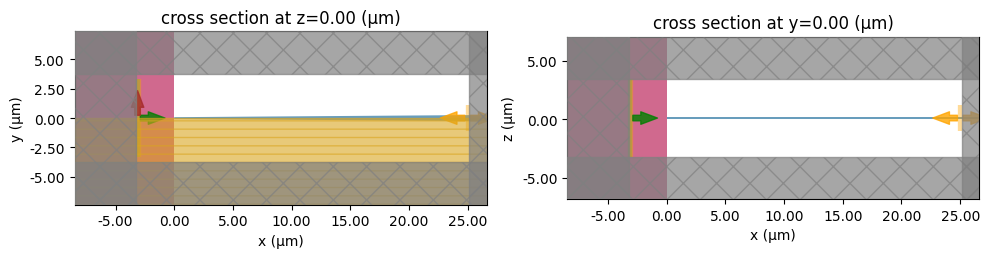

In [11]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)

sims = edge_coupler.models["Tidy3D"].get_simulations(edge_coupler, pf.C_0 / wavelengths)
_ = sims["P0@0"].plot(z=0, ax=ax[0])
_ = sims["P0@0"].plot(y=0, ax=ax[1])

Loading cached simulation from .tidy3d/pf_cache/F7T/fdtd_info-UKXVEK6Q53ZUZLBKZ7EU6WEP5XEID2GMTBBRTUJECCCBHEL3OMZA.json.
Loading cached simulation from .tidy3d/pf_cache/F7T/ms_info-UNTDJMX44KIKQ26WGIIPIGHPJQDH5V7QLUOR7SALGWQT3WS32EKQ.json.


Progress: 100% 


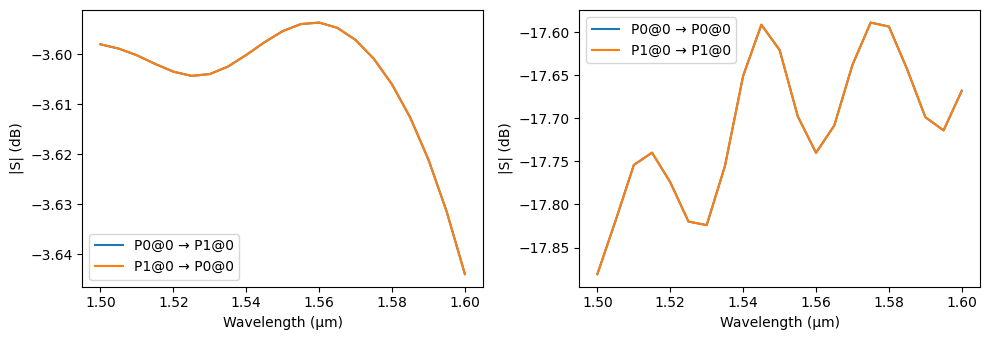

In [12]:
s_matrix_air = edge_coupler.s_matrix(pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_air, y="dB")

As expected, we see approximately 2.7 dB extra loss coming both from the added distance between the source and the chip, and the reflection from the refractive index mismatch. Moreover, we see an increased return loss of around -17 dB, which may be undesirable for some applications.

### Index-Matched Gap

In real devices, index matching fluid or packaging epoxy can be used to not only improve the coupling efficiency but also to provide structural support post packaging.
In order to see how adding an index matching layer affects the coupling losses while keeping the fiber at a fixed distance away from the chip we will define a new layer and an extrusion specification.

> We could, in this case, set the basic technology parameter `trench_medium` to the index matching fluid to the same effect, but this is a good example of technology customization that might be useful in cases where the technology function does not provide enough flexibility.

First, we define and add the new [layer](../_autosummary/photonforge.LayerSpec.rst):

In [13]:
matching_layer = pf.LayerSpec(
    (5, 0), "Index matching region", color=(30, 30, 155, 100), pattern="\\"
)
tech.add_layer("INDEX_MATCHING", matching_layer)
tech.layers

Name       Layer             Description               Color    Pattern
----------------------------------------------------------------------------
WG_CLAD         (1, 0)  Waveguide clad                    #9da6a218     .   
WG_CORE         (2, 0)  Waveguide core                    #6db5dd18     /   
SLAB            (3, 0)  Slab region                       #8851ad18     :   
TRENCH          (4, 0)  Deep-etched trench for chip fac…  #535e5918     +   
METAL           (5, 0)  Metal layer                       #b8a18b18     \   
INDEX_MATCHING  (5, 0)  Index matching region             #1e1e9b64     \

Then, we create a new [extrusion specification](../_autosummary/photonforge.ExtrusionSpec.rst) to extrude the structures in our new layer with the appropriate dimensions and medium.
Typically, the index of the index matching layer is close to but lower than the index of the SiO₂ cladding, so we will use refractive index of 1.4 for 
this simulation.

Note that this extrusion will be inserted *after* the core and slab extrusion rules, because we might want to override the structures from those steps with the index matching region.

In [14]:
medium_index_matching = td.Medium(permittivity=1.4**2, name="INDEX_MATCHING")
matching_extrusion = pf.ExtrusionSpec(
    pf.MaskSpec("INDEX_MATCHING"), medium_index_matching, (-pf.Z_INF, pf.Z_INF)
)
tech.insert_extrusion_spec(len(tech.extrusion_specs), matching_extrusion)
tech.extrusion_specs

#     Mask    Limits (μm)  Sidewal (°)       Opt. Medium              Elec. Medium      
----------------------------------------------------------------------------------------
0  'WG_CORE'    0, 0.22         0       cSi_Li1993_293K        Medium(permittivity=12.3)
1  'SLAB'       0, 0.07         0       cSi_Li1993_293K        Medium(permittivity=12.3)
2  'METAL'     1.72, 2.22       0       Cu_JohnsonChristy1972  PEC                      
3  'TRENCH'    -inf, inf        0       Medium()               Medium()                 
4  'METAL'     -inf, inf        0       INDEX_MATCHING         INDEX_MATCHING

In [15]:
edge_coupler = create_edge_coupler_with_facet(
    width_tip=0.15,
    length_taper=25,
    waist_radius=2.5 / 2,
    fiber_distance=3,
    trench_layer="INDEX_MATCHING",
)
edge_coupler

Next, we calculate the S parameters and plot it.

Loading cached simulation from .tidy3d/pf_cache/F5S/fdtd_info-NVKM6FQJ5WNER23HJOZ2Y2M575DC472PSP6ZHES22MRSXOSZHGBA.json.


Loading cached simulation from .tidy3d/pf_cache/F5S/ms_info-VCU2EF6RYZC2SH44NEXNEIX34QYN3FK4OXBJA663GVRAEOT4RFFA.json.
Progress: 100% 


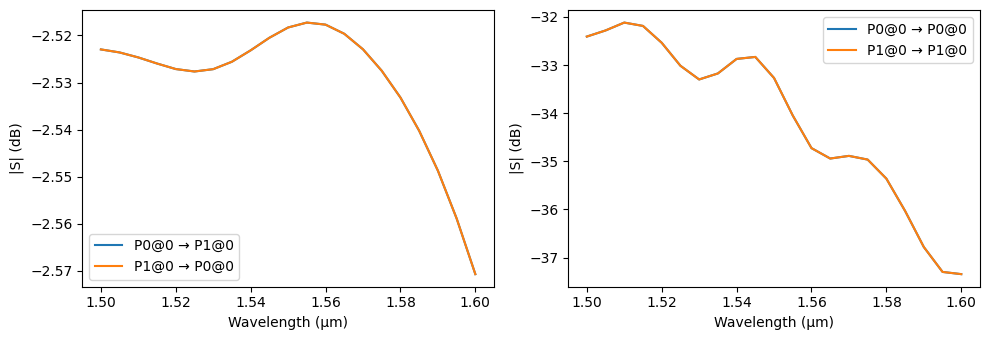

In [16]:
s_matrix_matched = edge_coupler.s_matrix(pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_matched, y="dB")

By introducing the index matching region, we are able to increase the coupling efficiency by 1 dB, as well as reduce the return losses to less than -30 dB.
From this point, we could further characterize how the position and angular alignment of the fiber affects the insertion and return losses.

Another interesting possibility is to use an angled taper to minimize return losses, which is critical in some applications and offers us the opportunity to demonstrate angled waveguide and Gaussian ports.

## Angled Inverse Taper

We will begin by creating a parametric function that allows us to create an angled edge coupler. At the output of the edge coupler, we will create an angled [port](../_autosummary/photonforge.Port.rst).

In [17]:
@pf.parametric_component
def create_angled_edge_coupler_with_facet(
    *,
    width_tip=0.1,
    length_taper=10,
    angle_taper=7,
    waist_radius=2.0,
    fiber_distance=3.0,
    angle_fiber=10.2,
    trench_layer="TRENCH"
):

    v_taper = np.array((np.cos(angle_taper / 180 * np.pi), np.sin(angle_taper / 180 * np.pi)))
    v_fiber = np.array((np.cos(angle_fiber / 180 * np.pi), np.sin(angle_fiber / 180 * np.pi)))

    component = pf.Component()
    component.add(
        "WG_CORE",
        pf.Path(-waist_radius * v_taper, width_tip)
        .segment((0, 0))
        .segment(length_taper * v_taper, core_width),
        "WG_CLAD",
        pf.Path(-waist_radius * v_taper, 4 * waist_radius)
        .segment((0, 0))
        .segment(length_taper * v_taper, clad_width),
        trench_layer,
        pf.Rectangle(
            (-fiber_distance - 10 * waist_radius, -10 * waist_radius), (0, 10 * waist_radius)
        ),
    )

    fiber_center = -fiber_distance * v_fiber
    port_fiber = pf.GaussianPort(
        center=(fiber_center[0], fiber_center[1], core_thickness / 2),
        input_vector=(v_fiber[0], v_fiber[1], 0),
        waist_radius=waist_radius,
        polarization_angle=0,  # for TE mode, in this case
    )
    port_waveguide = pf.Port(length_taper * v_taper, angle_taper + 180, port_spec)

    component.add_port([port_fiber, port_waveguide])

    model = pf.Tidy3DModel(
        port_symmetries=[("P0", "P1", {"P1": "P0"})],
        bounds=(
            (-fiber_distance - core_thickness, -3 * waist_radius, None),
            (None, max(3 * waist_radius, port_waveguide.center[1] + port_spec.width / (2 * v_taper[0])), None),
        ),
    )
    component.add_model(model, "Tidy3D")
    return component


create_angled_edge_coupler_with_facet()

In [18]:
angle_fiber = 15  # in degrees
# Fresnel diffraction
angle_taper = np.arcsin(np.sin(angle_fiber / 180 * np.pi) / 1.45) / np.pi * 180
print(f"Taper angle: {angle_taper}°")

edge_coupler = create_angled_edge_coupler_with_facet(
    width_tip=0.15,
    length_taper=25,
    angle_taper=angle_taper,
    waist_radius=2.5 / 2,
    fiber_distance=3,
    angle_fiber=angle_fiber,
    trench_layer="TRENCH",
)
edge_coupler

Taper angle: 10.282162084410936°


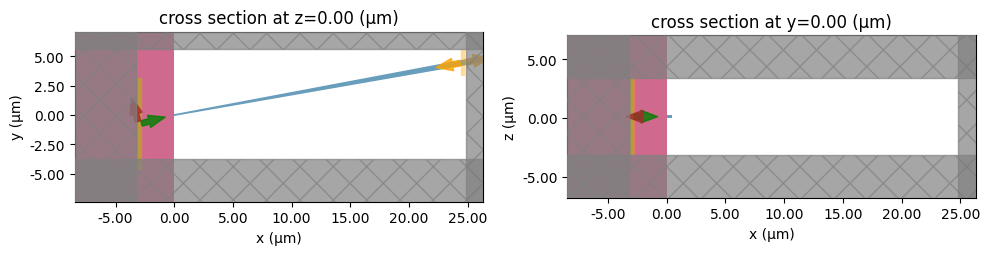

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)

sims = edge_coupler.models["Tidy3D"].get_simulations(edge_coupler, pf.C_0 / wavelengths)
_ = sims["P0@0"].plot(z=0, ax=ax[0])
_ = sims["P0@0"].plot(y=0, ax=ax[1])

Loading cached simulation from .tidy3d/pf_cache/HF5/fdtd_info-2JPXKNEJODFV6JM5VIUXO6G5OK4I6D6POQQDLXYQST5VZAUFBWFA.json.
Progress: 100% 


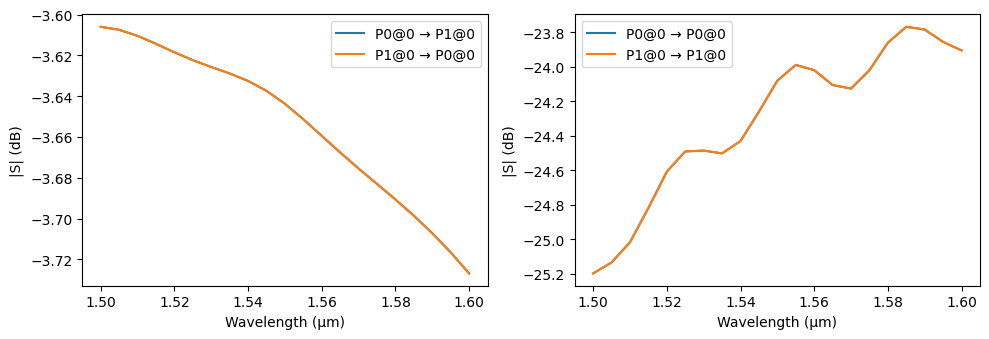

In [20]:
s_matrix_tilted = edge_coupler.s_matrix(pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_tilted, y="dB")

We see that the insertion loss has essentially remained the same when compared to the straight edge coupler with air gap, but the return loss has improved more than 6 dB.